In [2]:
import os
import re
import pandas as pd
from scipy.stats import kruskal

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.patches as mpatches
from collections import Counter

import torch

from utils.llm_summarizer import Summarizer

import utils.params as P
from utils.fileIO import read_json2list, dump_list2json
from utils.other import listEntries_to_dictEntries, extract_key_structure
from utils.optimization import normalize_algorithms, method2category
from utils.constant import ADDED_FEATURES

torch.cuda.is_available()

True


# DOME Report (focus on GigaScience Journal)
23 May 2025

Report DOC: https://docs.google.com/document/d/17rlxdggLQEpHaIhmuRAxY6Rzn9fB9BHuS-g5KQJ-9Rk/edit?tab=t.6kfax130q6i4


## 1. Load Data

In [3]:
list_entries = read_json2list(P.path_registry_data_processed_json)
dict_entries = listEntries_to_dictEntries(list_entries)

dict_entry_key_struc = extract_key_structure(list_entries[0])

list_entries_GigaScience = [entry for entry in list_entries if entry['publication']['journal']=='GigaScience']
dict_entries_GigaScience = listEntries_to_dictEntries(list_entries_GigaScience)

print(f"Number of entries in total: {len(list_entries)}")
print(f"Number of entries GigaScience: {len(list_entries_GigaScience)}")

Number of entries in total: 312
Number of entries GigaScience: 77


**Output Path**

In [64]:
path_figure1 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_skipFieldCount.png")
path_figure2 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_scoreDistribution.png")
path_figure3 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_publications_per_year.png")
path_figure4 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_curations_per_curator.png")
path_figure5 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_computational_methods_treemap.html")
path_figure6 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_computational_methods_treemap.pdf")
path_table2 = os.path.join(P.PATH_Output_GigaScience, 'GigaScience_computational_methods_table.csv')
path_figure7 = os.path.join(P.PATH_Output_GigaScience, "GigaScience_ml_methods_by_year_percentage.png")
# path_figure = os.path.join(P.PATH_Output_GigaScience, )

## 2. General analysis

Number of publications, number of curators, number of fields:21. 
Data-4, optimization-8, model-4, evaluation-5

Fields are empty

Score distribution

### 2.1. Figure 1: skip field count

In [19]:
list_4area = ['dataset', 'optimization', 'model', 'evaluation']

dict_skip_field_count = {area: {sub_area: 0 for sub_area in dict_entry_key_struc[area] if sub_area not in ADDED_FEATURES[area]} for area in list_4area}
for entry in list_entries_GigaScience:
    for area in list_4area:
        for sub_area in dict_skip_field_count[area].keys():
            answer = entry[area][sub_area]
            if answer == "" or bool(re.fullmatch(r'\bno\b[\.,]?', answer.strip(), re.IGNORECASE)):
                dict_skip_field_count[area][sub_area] += 1

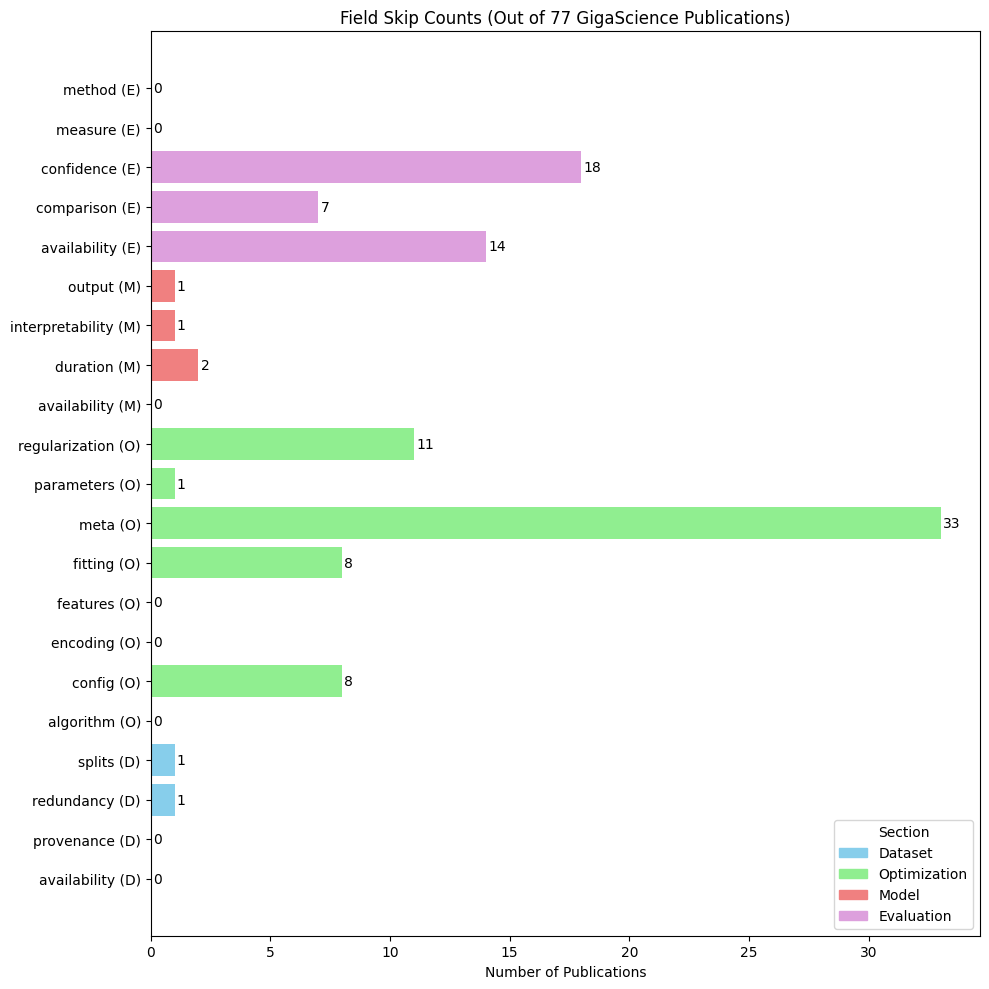

In [20]:
# Skip counts data
data = dict_skip_field_count

# Color mapping per category
color_map = {
    'dataset': 'skyblue',
    'optimization': 'lightgreen',
    'model': 'lightcoral',
    'evaluation': 'plum'
}

# Flatten data
flat_keys = []
flat_values = []
colors = []
categories = []

for category, subdict in data.items():
    for subkey, value in subdict.items():
        flat_keys.append(f"{subkey} ({category[0].upper()})")
        flat_values.append(value)
        colors.append(color_map[category])
        categories.append(category)

# Plot
plt.figure(figsize=(10, 10))  # Taller figure for horizontal layout
bars = plt.barh(flat_keys, flat_values, color=colors)  # Horizontal bars

plt.xlabel("Number of Publications")
plt.title("Field Skip Counts (Out of 77 GigaScience Publications)")

# Annotate each bar with value
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, str(width), ha='left', va='center', fontsize=10)

# Legend
legend_patches = [mpatches.Patch(color=color, label=cat.capitalize()) for cat, color in color_map.items()]
plt.legend(handles=legend_patches, title="Section", loc='lower right')

plt.tight_layout()
plt.savefig(path_figure1, dpi=300, bbox_inches='tight')
plt.show()


### 2.2. Figure 2: SCORE distribution of the 77 GigaScience publications.

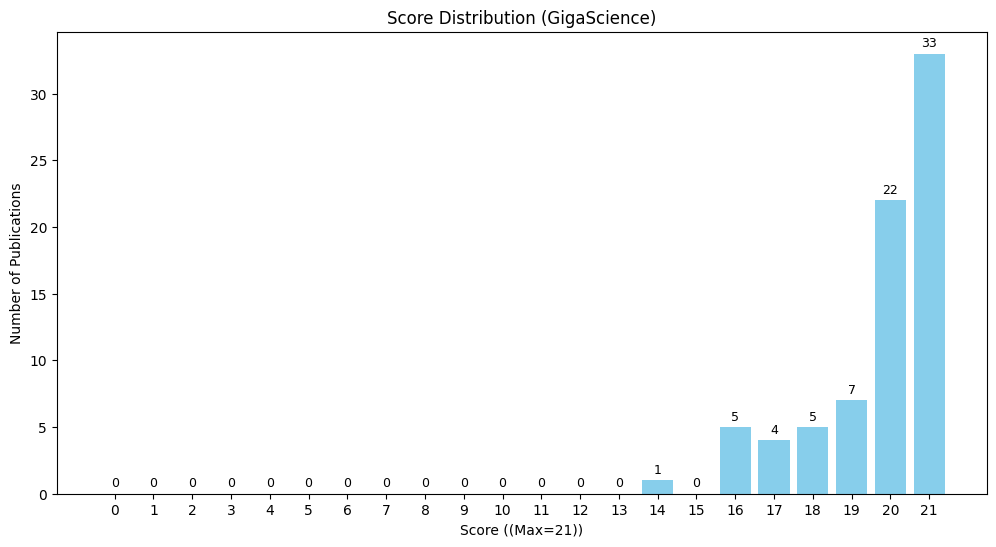

In [35]:
# Score list — []
scores = [entry['score'] for entry in list_entries_GigaScience]

# Count frequency of each score from 0 to 21
score_range = list(range(0, 22))  # 0 to 21
score_counts = Counter(scores)
frequencies = [score_counts.get(score, 0) for score in score_range]

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(score_range, frequencies, color='skyblue')

# Labels & title
plt.xticks(score_range)
plt.xlabel("Score ((Max=21))")
plt.ylabel("Number of Publications")
plt.title("Score Distribution (GigaScience)")

# Annotate each bar with its value
for bar, count in zip(bars, frequencies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, str(count), 
             ha='center', va='bottom', fontsize=9)

# Save the figure
plt.savefig(path_figure2, dpi=300, bbox_inches='tight')
plt.show()

### 2.3. Year-Publications

In [26]:
dict_year_publications = {}
for entry in list_entries_GigaScience:
    year = entry['publication']['year']
    if not year.isnumeric():
        continue
    
    _id = entry['_id']
    if year in dict_year_publications:
        dict_year_publications[year]['count'] = dict_year_publications[year]['count'] + 1
        dict_year_publications[year]['_ids'].append(_id)
    else:
        dict_year_publications[year] = {'count': 1, '_ids': [_id]}
    
    

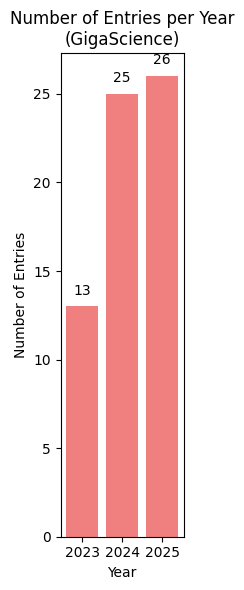

In [34]:

# Step 1: Extract and sort years
years = sorted(dict_year_publications.keys())
counts = [dict_year_publications[year]['count'] for year in years]

# Step 2: Plot
plt.figure(figsize=(2, 6))
bars = plt.bar(years, counts, color='lightcoral')
plt.title("Number of Entries per Year\n(GigaScience)")
plt.xlabel("Year")
plt.ylabel("Number of Entries")

# Annotate bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count),
             ha='center', va='bottom', fontsize=10)

# Save & show
plt.tight_layout()
plt.savefig(path_figure3, dpi=300)
plt.show()

### 2.4. Curator--Publications

In [38]:
dict_user_publications = {} # {'user_id': {'name': , 'publication_ids': []}}
for entry in list_entries_GigaScience:
    usr_id =  entry['user']['_id']
    if usr_id in dict_user_publications:
        dict_user_publications[usr_id]['publication_ids'].append(entry['_id'])
    else:
        dict_user_publications[usr_id] = {'publication_ids': [entry['_id']]}
        
for usr_id, pub in dict_user_publications.items():
    list_pub_id = pub['publication_ids']
    list_score = [dict_entries[_id]['score'] for _id in list_pub_id]
    avg_score = sum(list_score)/len(list_pub_id)
    
    dict_user_publications[usr_id]['usr_id'] = usr_id
    dict_user_publications[usr_id]['num_pub'] = len(list_pub_id)
    dict_user_publications[usr_id]['scores'] = list_score
    dict_user_publications[usr_id]['avg_score'] = avg_score

In [2]:
# pd.DataFrame.from_dict(dict_user_publications, orient='index').sort_values(by=['num_pub', 'avg_score'])

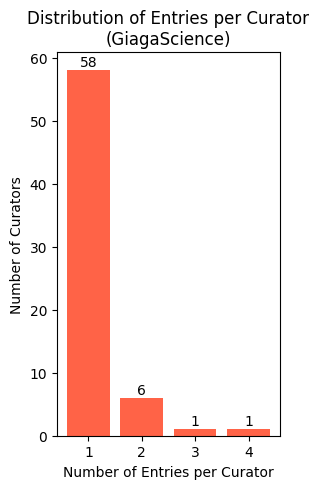

In [44]:
# Count how many curators have each num_pub value
counts = Counter([c['num_pub'] for _, c in dict_user_publications.items()])
df = pd.DataFrame(sorted(counts.items()), columns=['Num_Entries', 'Num_Curators'])

# Plot
plt.figure(figsize=(3, 5))
bars = plt.bar(df['Num_Entries'], df['Num_Curators'], color='tomato')

plt.xticks(df['Num_Entries'])

plt.xlabel("Number of Entries per Curator")
plt.ylabel("Number of Curators")
plt.title("Distribution of Entries per Curator\n(GiagaScience)")

# Annotate counts on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, str(height),
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(path_figure4, dpi=300)
plt.show()

## 3. Analysis on the User Answers (Based on LLm results)

summarize the user's answers, especially for answers including Y/N. 4 Sections: dataset, optimization, model and evaluation.

#### a. Availability

In [48]:
num_avail_dataset = {'yes':0, 'request':0, 'no':0}
num_avail_model = {'yes':0, 'request':0, 'no':0}
# num_avail_config = {'yes':0, 'request':0, 'no':0}

num_avail_dataset_license = {'yes':0, 'no':0}
num_avail_model_license = {'yes':0, 'no':0}

for entry in list_entries_GigaScience:
    dataset = entry['dataset']
    model = entry['model']
    num_avail_dataset[dataset['availability_llm']] = num_avail_dataset[dataset['availability_llm']] + 1
    num_avail_dataset_license[dataset['availability_license']] = num_avail_dataset_license[dataset['availability_license']] + 1
    
    num_avail_model[model['availability_label']] = num_avail_model[model['availability_label']] + 1
    num_avail_model_license[model['license']] = num_avail_model_license[model['license']] + 1

In [49]:
num_avail_dataset, num_avail_model, num_avail_dataset_license, num_avail_model_license

({'yes': 72, 'request': 2, 'no': 3},
 {'yes': 75, 'request': 0, 'no': 2},
 {'yes': 40, 'no': 37},
 {'yes': 69, 'no': 8})

#### b. Computational Methods

Plot Year and Number of publications.

Separate year into several chunks. Year-ML, availibility, ...

In [50]:
dict_algorithm_count = {}
for entry in list_entries_GigaScience:
    for alg in entry['optimization']['algorithm_names']:
        if alg in dict_algorithm_count:
            dict_algorithm_count[alg]['count'] = dict_algorithm_count[alg]['count'] + 1
        else:
            dict_algorithm_count[alg] = {'method': alg, 'count': 1, 'category': method2category([alg])[0]}
dict_algorithm_count

{'clustering': {'method': 'clustering',
  'count': 2,
  'category': 'Unsupervised Learning'},
 'gradient boosting': {'method': 'gradient boosting',
  'count': 7,
  'category': 'Traditional ML'},
 'other': {'method': 'other', 'count': 8, 'category': 'Other / Unclassified'},
 'logistic regression': {'method': 'logistic regression',
  'count': 6,
  'category': 'Traditional ML'},
 'rf': {'method': 'rf', 'count': 17, 'category': 'Traditional ML'},
 'knn': {'method': 'knn', 'count': 2, 'category': 'Traditional ML'},
 'naive bayes': {'method': 'naive bayes',
  'count': 1,
  'category': 'Bayesian / Probabilistic'},
 'neural network': {'method': 'neural network',
  'count': 12,
  'category': 'Deep Learning'},
 'svm': {'method': 'svm', 'count': 4, 'category': 'Traditional ML'},
 'xgboost': {'method': 'xgboost', 'count': 3, 'category': 'Traditional ML'},
 'cnn': {'method': 'cnn', 'count': 13, 'category': 'Deep Learning'},
 'linear regression': {'method': 'linear regression',
  'count': 3,
  'cate

In [51]:
df_data = pd.DataFrame.from_dict(dict_algorithm_count, orient='index')

In [53]:
fig = px.treemap(
    df_data,
    path=["category", "method"],  # Grouping hierarchy
    values="count",
    color="category",
    title="Computational Methods by Category",
)

fig.update_traces(textinfo="label+value")
fig.write_html(path_figure5)
fig.write_image(path_figure6, width=1200, height=800)
fig.show()


**Save Table info**

In [56]:
df_data.to_csv(path_table2, index=None)

#### c. Computational Methods--Year

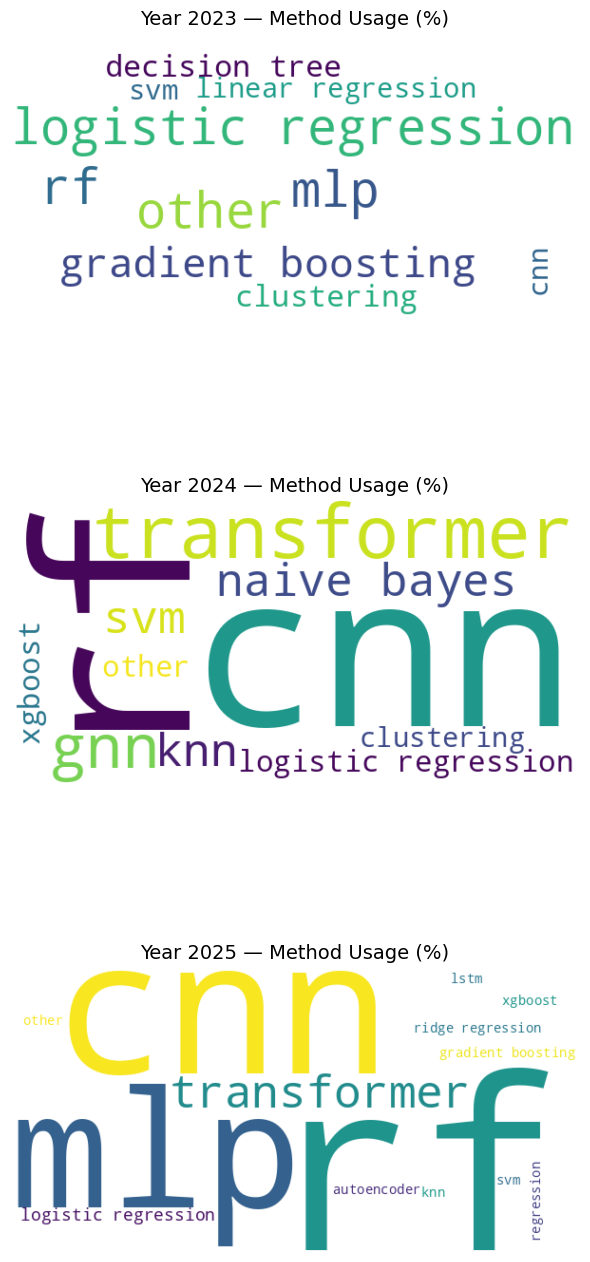

In [65]:
data_CM_year = []
for entry in list_entries_GigaScience:
    y = entry['publication']['year']
    
    if not y.isnumeric(): # not published yet
        continue
    
    method = entry['optimization']['algorithm_names']
    # if 'neural network' in method: method.remove('neural network')
    try:
        if len(method)==0:
            continue
    except:
        print(entry['optimization'])
        
    d = {
        'Year': y,
        'Method': method
        }
    data_CM_year.append(d)

# Step 2: Flatten to one row per method per year
rows = []
for entry in data_CM_year:
    year = entry["Year"]
    for method in entry["Method"]:
        rows.append({"Year": year, "Method": method})

df = pd.DataFrame(rows)

# Step 3: Prepare vertical layout
years = sorted(df["Year"].unique())
fig, axes = plt.subplots(len(years), 1, figsize=(6, 5 * len(years)))

if len(years) == 1:
    axes = [axes]

for ax, year in zip(axes, years):
    year_data = df[df["Year"] == year]
    total = len(year_data)
    freq = year_data["Method"].value_counts()
    freq_percent = (freq / total * 100).round(1).to_dict()  # percentage values

    # WordCloud uses frequencies; we scale them as-is (font size reflects %)
    wc = WordCloud(width=600, height=300, background_color="white")
    wc.generate_from_frequencies(freq_percent)

    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(f"Year {year} — Method Usage (%)", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.savefig(path_figure7, dpi=300)
plt.show()

In [58]:
list_entries_GigaScience

[{'_id': '63a25db2e8edf6ce46f6e84b',
  'uuid': '8c0c94cd-3172-4f65-92b0-b997742324e0',
  'created': '2022-12-21T01:13:22.874Z',
  'updated': '2022-12-21T01:38:36.717Z',
  'public': True,
  'user': {'_id': '63992de57417daebc3c00985',
   'orcid': '0000-0003-2051-487X',
   '__v': 0,
   'name': 'qian luo',
   'roles': 'user',
   'organisation': 'undefined',
   'organizations': ['academia']},
  'publication': {'authors': 'Ang Guo, Zhiyu Chen, Fang Li, and Qian Luo',
   'doi': '10.1093/gigascience/giad021',
   'journal': 'GigaScience',
   'pmid': '37039115',
   'title': 'Delineating Regions-of-interest for Mass Spectrometry Imaging by Multimodally Corroborated Spatial Segmentation',
   'year': '2023',
   'done': 0,
   'skip': 0,
   'tags': [],
   'clear_doi': '10.1093/gigascience/giad021',
   'clear_pmid': '37039115',
   'pmcid': '10087011'},
  'dataset': {'availability': 'Yes, The MSI data have been deposited to the ProteomeXchange Consortium (http://proteomecentral.proteomexchange.org) via